<a href="https://colab.research.google.com/github/elizabethiva/Machine_Learning_Portfolio/blob/main/BBC_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BBC News Classification
The goal of this project is to build a system capable of accurately classifying previously unseen news articles into the correct category.
In this project, we utilize the [BBC News Classification Dataset](https://www.kaggle.com/c/learn-ai-bbc/overview), which comprises 2225 instances of news articles along with their corresponding labels.

In [42]:
import requests
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [43]:
# Get BBC News Classification Dataset
url = 'https://raw.githubusercontent.com/elizabethiva/Machine_Learning_Portfolio/main/data/bbc-text.csv'

In [44]:
# Download the content of the CSV file
response = requests.get(url)
csv_content = response.text

# Split the content into lines
csv_lines = csv_content.split('\n')

# Path to the file where the dataset will be saved
bbc_text = 'bbc-text.csv'

# Save the dataset to a CSV file
with open(bbc_text, 'w') as csv_file:
    csv_file.write(csv_content)

By running the cell below, you can see what the dataset looks like.

In [45]:
with open(bbc_text, 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

Each data point looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially

# Defining useful global variables
- `NUM_WORDS`: The maximum number of words to keep, based on word frequency. Defaults to 1000.


- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.


- `MAXLEN`: Maximum length of all sequences. Defaults to 120.


- `PADDING`: Padding strategy. Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "\<OOV>".

    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.8

In [46]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

# Loading and pre-processing the data
The `remove_stopwords` function removes stopwords from the text, and the parse_data_from_file function extracts sentences and labels from a CSV file.

In [47]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (string): sentence to remove the stopwords from

    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [48]:
sentences, labels = parse_data_from_file(bbc_text)


# Training - Validation Split
The `train_val_split` function splits the full lists of sentences and labels into training and validation sentences and labels.

In [49]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set

    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(training_split * len(sentences))

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [50]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

# Tokenization - Sequences and padding
The `fit_tokenizer` function returns a Tokenizer that has been fitted to the training sentences.

In [51]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """

    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [61]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

The `seq_and_pad` function converts each text data point into its padded sequence representation.

In [53]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence

    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)

    return padded_sequences

In [54]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

Finally we need to tokenize the labels.

In [55]:
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels

    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize

    Returns:
        label_seq_np (array of int): tokenized labels
    """

    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()

    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)

    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)

    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1

    return label_seq_np

In [56]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

The `create_model` defines the model that classifies each text as being part of a certain category. The model architecture is designed to achieve an accuracy of 95% for validation data.

In [57]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)


    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(5, activation='sigmoid')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [58]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=40, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/40
56/56 [==============================] - 1s 7ms/step - loss: 1.6004 - accuracy: 0.3112 - val_loss: 1.5881 - val_accuracy: 0.3124
Epoch 2/40
56/56 [==============================] - 0s 3ms/step - loss: 1.5641 - accuracy: 0.3854 - val_loss: 1.5378 - val_accuracy: 0.4742
Epoch 3/40
56/56 [==============================] - 0s 5ms/step - loss: 1.4832 - accuracy: 0.5039 - val_loss: 1.4337 - val_accuracy: 0.5573
Epoch 4/40
56/56 [==============================] - 0s 4ms/step - loss: 1.3337 - accuracy: 0.6326 - val_loss: 1.2618 - val_accuracy: 0.6809
Epoch 5/40
56/56 [==============================] - 0s 4ms/step - loss: 1.1286 - accuracy: 0.7590 - val_loss: 1.0582 - val_accuracy: 0.7933
Epoch 6/40
56/56 [==============================] - 0s 3ms/step - loss: 0.9147 - accuracy: 0.8573 - val_loss: 0.8648 - val_accuracy: 0.8831
Epoch 7/40
56/56 [==============================] - 0s 5ms/step - loss: 0.7205 - accuracy: 0.9129 - val_loss: 0.6969 - val_accuracy: 0.9169
Epoch 8/40
56/56 [==

 You can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

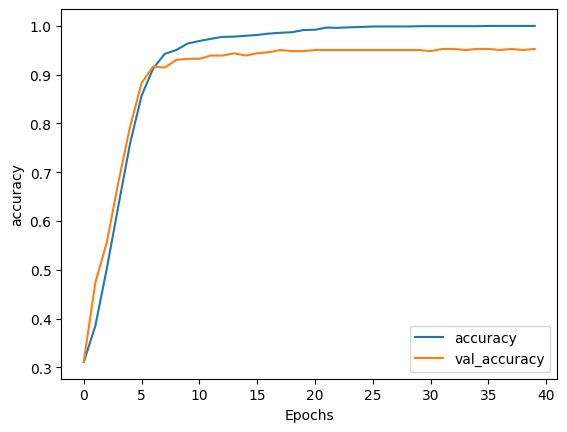

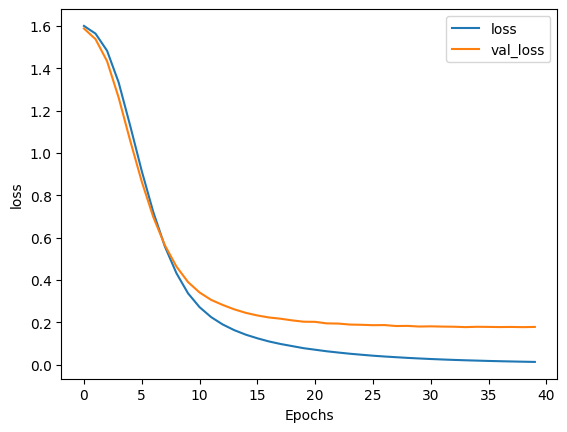

In [59]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Visualizing 3D Vectors
You can visualize the vectors associated with each word in the training set in a 3D space.

For this run the following cells and visit [Tensorflow's Embedding Projector](https://projector.tensorflow.org/).

In [62]:
# Reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


 Run the following cell to generate the `vecs.tsv` and `meta.tsv` files that you will upload to the embedding projector.

In [65]:
# Generate files for embedding visualization
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

By running the previous cell, these files are placed within your filesystem. To download them, click on the file icon on the upper-left side of the screen. This will take you to the Google Colab filesystem, and there you can download the files by clicking on the vertical ellipsis and then clicking on the Download button.